In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load images
img1 = cv2.imread('/content/IMG_1st.jpeg')
img2 = cv2.imread('/content/IMG_2nd.jpeg')
img3 = cv2.imread('/content/IMG_3th.jpeg')
img4 = cv2.imread('/content/IMG_4th.jpeg')

# Convert to RGB image
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3_rgb = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img4_rgb = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)

# Convert to grayscale image
img1_gray = cv2.cvtColor(img1_rgb, cv2.COLOR_RGB2GRAY)
img2_gray = cv2.cvtColor(img2_rgb, cv2.COLOR_RGB2GRAY)
img3_gray = cv2.cvtColor(img3_rgb, cv2.COLOR_RGB2GRAY)
img4_gray = cv2.cvtColor(img4_rgb, cv2.COLOR_RGB2GRAY)

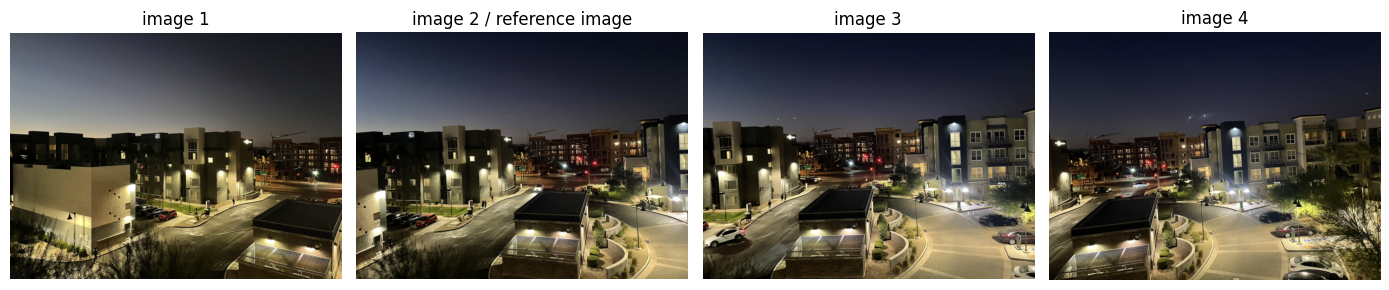

In [ ]:
plt.figure(figsize = (14,6))
plt.subplot(1,4,1)
plt.imshow(img1_rgb)
plt.title('image 1')
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(img2_rgb)
plt.title('image 2 / reference image')
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(img3_rgb)
plt.title('image 3')
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(img4_rgb)
plt.title('image 4')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Function to extract keypoints and descriptors
def feature_extractor(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

In [ ]:
# Function to match keypoints between two images with 1NN/2NN ratio test
def match_keypoints(descriptors1, descriptors2, ratio=None):
    bf = cv2.BFMatcher(cv2.NORM_L2)
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    # ratio test according to paper.
    good_matches = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good_matches.append(m)

    return good_matches

In [ ]:
# Function to stitch two images
def stitch_images(img1, img2, homography=None, alpha=None):
    if homography is None:
        return np.concatenate((img1, img2), axis=1)

    # using homography, Warping
    img2_warped = cv2.warpPerspective(img2, homography, (int(0.9*(img1.shape[1] + img2.shape[1])), img1.shape[0]), flags=cv2.WARP_INVERSE_MAP)

    # Copy the first image to the result canvas and overlay the first image using alpha b;ending.
    result = img2_warped.copy()
    result[:, :img1.shape[1], :] = cv2.addWeighted(img1, alpha, result[:, :img1.shape[1], :], 1 - alpha, 0)
    result = np.clip(result, 0, 255).astype(np.uint8)

    return result

In [ ]:
# Extract keypoints and descriptors for the second and third images
keypoints2, descriptors2 = feature_extractor(img2_rgb)
keypoints3, descriptors3 = feature_extractor(img3_rgb)

In [ ]:
# Match keypoints between the second and third images with 1NN/2NN ratio test
matches_2_3 = match_keypoints(descriptors2, descriptors3, ratio=0.5)

In [ ]:
# Find homography matrix for the second and third images (img2 as reference)
src_points_2_3 = np.float32([keypoints2[match.queryIdx].pt for match in matches_2_3]).reshape(-1, 1, 2)
dst_points_2_3 = np.float32([keypoints3[match.trainIdx].pt for match in matches_2_3]).reshape(-1, 1, 2)
homography_2_3, _ = cv2.findHomography(src_points_2_3, dst_points_2_3, cv2.RANSAC, 5.0)

In [ ]:
# Stitch the second and third images
stitched_2_3 = stitch_images(img2_rgb, img3_rgb, homography_2_3, alpha=0.9)
stitched_2_3_gray = cv2.cvtColor(stitched_2_3, cv2.COLOR_RGB2GRAY)

In [ ]:
# Extract keypoints and descriptors for the first image
keypoints1, descriptors1 = feature_extractor(img1_rgb)

# Extract keypoints and descriptors for the stitched image and the first image
keypoints_stitched, descriptors_stitched = feature_extractor(stitched_2_3)
keypoints1, descriptors1 = feature_extractor(img1_rgb)

# Match keypoints between the first and stitched images
matches_1_stitched = match_keypoints(descriptors1, descriptors_stitched, ratio=0.4)


In [ ]:
# Check if matches_1_stitched is not empty before accessing elements
if matches_1_stitched:
    # Find homography matrix between the first image and the stitched image
    src_points_1_stitched = np.float32([keypoints1[match.queryIdx].pt for match in matches_1_stitched]).reshape(-1, 1, 2)
    dst_points_1_stitched = np.float32([keypoints_stitched[match.trainIdx].pt for match in matches_1_stitched]).reshape(-1, 1, 2)
    homography_1_stitched, _ = cv2.findHomography(src_points_1_stitched, dst_points_1_stitched, cv2.RANSAC, 7.0)

    # Stitch the first image to the result of the second and third with a different alpha value
    stitched_final = stitch_images(img1_rgb, stitched_2_3, homography_1_stitched, alpha=0.7)
else:
    print("No matches found between the first image and the stitched image.")

In [ ]:
# Extract keypoints and descriptors for the final stitched image and the fourth image
keypoints_stitched_final, descriptors_stitched_final = feature_extractor(stitched_final)
keypoints4, descriptors4 = feature_extractor(img4_rgb)

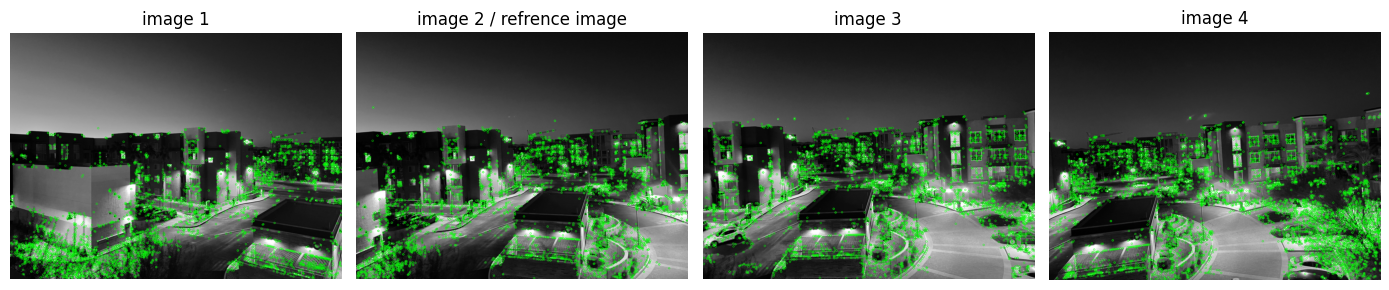

In [ ]:
plt.figure(figsize = (14,6))
plt.subplot(1,4,1)
plt.imshow(cv2.drawKeypoints(img1_gray, keypoints1, None, color=(0,255,0)))
plt.title('image 1')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(cv2.drawKeypoints(img2_gray, keypoints2, None, color=(0,255,0)))
plt.title('image 2 / refrence image')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(cv2.drawKeypoints(img3_gray, keypoints3, None, color=(0,255,0)))
plt.title('image 3')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(cv2.drawKeypoints(img4_gray, keypoints4, None, color=(0,255,0)))
plt.title('image 4')
plt.axis('off')

plt.tight_layout()
plt.show()

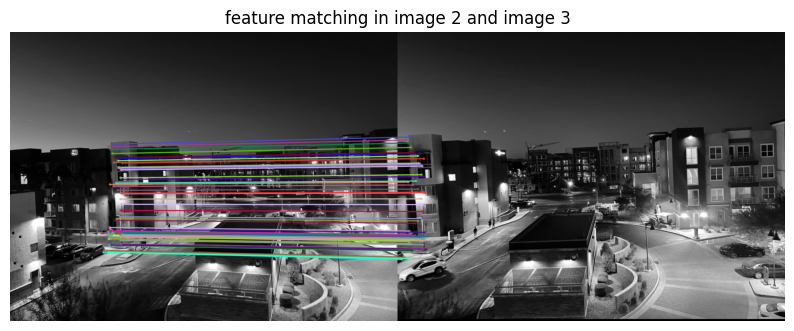

In [ ]:
img_23 = cv2.drawMatches(img2_gray, keypoints2, img3_gray, keypoints3, matches_2_3[:70], img2_gray, flags=2, matchesThickness=2)
plt.figure(figsize = (10,7))
plt.imshow(img_23)
plt.title('feature matching in image 2 and image 3')
plt.axis('off')
plt.show()

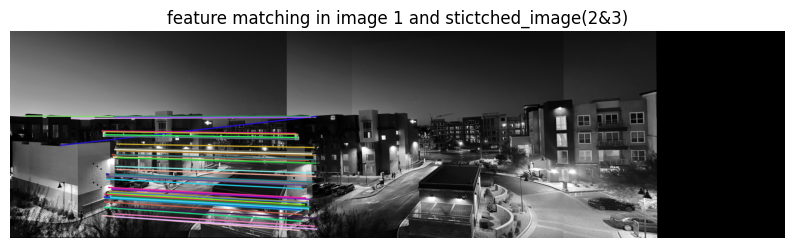

In [ ]:
img_1_23 = cv2.drawMatches(img1_gray, keypoints1, stitched_2_3_gray, keypoints_stitched, matches_1_stitched[:50], img2_gray, flags=2, matchesThickness=3)
plt.figure(figsize = (10,7))
plt.imshow(img_1_23)
plt.title('feature matching in image 1 and stictched_image(2&3)')
plt.axis('off')
plt.show()

In [ ]:
img_23_4 = cv2.drawMatches(stitched_final, keypoints1, img4_gray, keypoints4, matches_stitched_final_4[:80], img2_gray, flags=2, matchesThickness=2)
plt.figure(figsize = (10,7))
plt.imshow(img_23_4)
plt.title('feature matching in stictched_image(2&3) and image 4')
plt.axis('off')
plt.show()

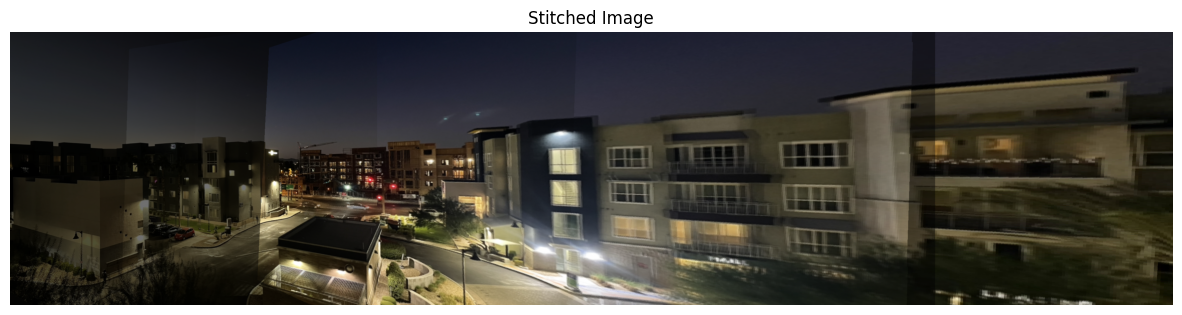

In [ ]:

# Match keypoints between the final stitched image and the fourth image with 1NN/2NN ratio test
matches_stitched_final_4 = match_keypoints(descriptors_stitched_final, descriptors4, ratio=0.5)

# Check if matches_stitched_final_4 is not empty before accessing elements
if matches_stitched_final_4:
    # Find homography matrix between the final stitched image and the fourth image
    src_points_stitched_final_4 = np.float32([keypoints_stitched_final[match.queryIdx].pt for match in matches_stitched_final_4]).reshape(-1, 1, 2)
    dst_points_stitched_final_4 = np.float32([keypoints4[match.trainIdx].pt for match in matches_stitched_final_4]).reshape(-1, 1, 2)
    homography_stitched_final_4, _ = cv2.findHomography(src_points_stitched_final_4, dst_points_stitched_final_4, cv2.RANSAC, 5.0)

    # Stitch the fourth image to the final stitched result with a different alpha value
    stitched_final_2 = stitch_images(stitched_final, img4_rgb, homography_stitched_final_4, alpha=0.45)

    # Display the final stitched result
    plt.figure(figsize=(15, 10))
    plt.imshow(stitched_final_2)
    plt.title('Stitched Image')
    plt.axis('off')
    plt.show()
else:
    print("No matches found between the final stitched image and the fourth image.")

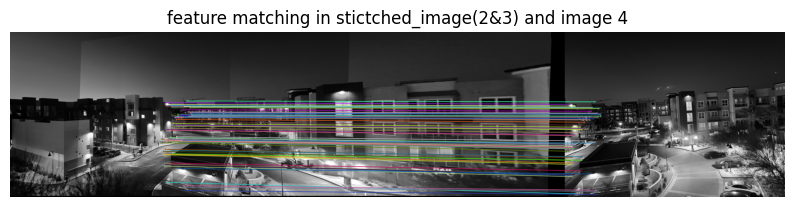

In [ ]:
stitched_final_gray = cv2.cvtColor(stitched_final, cv2.COLOR_RGB2GRAY)
img_23_4 = cv2.drawMatches(stitched_final_gray, keypoints_stitched_final, img4_gray, keypoints4, matches_stitched_final_4[:80], img2_gray, flags=2, matchesThickness=2)
plt.figure(figsize = (10,7))
plt.imshow(img_23_4)
plt.title('feature matching in stictched_image(2&3) and image 4')
plt.axis('off')
plt.show()

Homography

In [ ]:

np.set_printoptions(precision=3, suppress=False)

# the homography matrix
print('-------------------')
print('homography matrix(1) between image 2 and image 3 :')
print('-------------------')
print(homography_2_3)
print('------------------------------------')

print('-------------------')
print('homography matrix(2) between image 1 and stitched image(2&3):')
print('-------------------')
print(homography_1_stitched)
print('------------------------------------')

print('-------------------')
print('homography matrix(3) between stitched image(1&2&3)and image 4:')
print('-------------------')
print(homography_stitched_final_4)
print('------------------------------------')

-------------------
homography matrix between image 2 and image 3 :
-------------------
[[ 1.450e+00  5.867e-03 -4.013e+02]
 [ 1.457e-01  1.270e+00 -1.194e+02]
 [ 3.798e-04  9.573e-06  1.000e+00]]
------------------------------------
-------------------
homography matrix between image 1 and stitched image(2&3):
-------------------
[[ 1.731e+00  5.416e-02 -6.599e+02]
 [ 2.084e-01  1.469e+00 -1.625e+02]
 [ 6.135e-04  1.853e-05  1.000e+00]]
------------------------------------
-------------------
homography matrix between stitched image(1&2&3)and image 4:
-------------------
[[ 1.175e+01  5.991e-01 -9.731e+03]
 [ 3.281e+00  1.014e+01 -3.244e+03]
 [ 8.970e-03  4.099e-04  1.000e+00]]
------------------------------------


Reprojection Error

In [ ]:
#reprojection error
reprojection_errors = np.sqrt(np.sum((cv2.perspectiveTransform(src_points_2_3, homography_2_3) - dst_points_2_3) ** 2, axis=2))
mean_reprojection_error = np.mean(reprojection_errors)
print("Mean Reprojection Error(homography matrix 1):", mean_reprojection_error)

reprojection_errors = np.sqrt(np.sum((cv2.perspectiveTransform(src_points_1_stitched, homography_1_stitched) - dst_points_1_stitched ) ** 2, axis=2))
mean_reprojection_error = np.mean(reprojection_errors)
print("Mean Reprojection Error(homography matrix 2):", mean_reprojection_error)

reprojection_errors = np.sqrt(np.sum((cv2.perspectiveTransform(src_points_stitched_final_4, homography_stitched_final_4) - dst_points_stitched_final_4) ** 2, axis=2))
mean_reprojection_error = np.mean(reprojection_errors)
print("Mean Reprojection Error(homography matrix 3):", mean_reprojection_error)

Mean Reprojection Error(homography matrix 1): 0.98071605
Mean Reprojection Error(homography matrix 2): 6.6669283
Mean Reprojection Error(homography matrix 3): 1.0292215
